In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
from torch.nn.init import _calculate_fan_in_and_fan_out
from timm.layers import to_2tuple, trunc_normal_
import os
import torchvision.utils as utils
import torch.utils.data as data
from torch.utils.data import DataLoader
import glob
from torchvision.transforms import ToTensor, Normalize, Compose, ToPILImage
from torchvision.models import vgg16
from torch.utils.data import Dataset
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from random import randrange
import time
from math import log10
from skimage import measure
import ipywidgets as widgets
from IPython.display import display
from torch.nn.init import trunc_normal_
import matplotlib.pyplot as plt

## RevisedLayerNorm

In [42]:
class RevisedLayerNorm(nn.Module):
    """Revised LayerNorm"""
    def __init__(self, embed_dim, epsilon=1e-5, detach_gradient=False):
        super(RevisedLayerNorm, self).__init__()
        self.epsilon = epsilon
        self.detach_gradient = detach_gradient

        self.scale = nn.Parameter(torch.ones((1, embed_dim, 1, 1)))
        self.shift = nn.Parameter(torch.zeros((1, embed_dim, 1, 1)))

        self.scale_mlp = nn.Conv2d(1, embed_dim, 1)
        self.shift_mlp = nn.Conv2d(1, embed_dim, 1)

        trunc_normal_(self.scale_mlp.weight, std=.02)
        nn.init.constant_(self.scale_mlp.bias, 1)

        trunc_normal_(self.shift_mlp.weight, std=.02)
        nn.init.constant_(self.shift_mlp.bias, 0)

    def forward(self, input_tensor):
        mean_value = torch.mean(input_tensor, dim=(1, 2, 3), keepdim=True)
        std_value = torch.sqrt((input_tensor - mean_value).pow(2).mean(dim=(1, 2, 3), keepdim=True) + self.epsilon)

        normalized_tensor = (input_tensor - mean_value) / std_value

        if self.detach_gradient:
            rescale, rebias = self.scale_mlp(std_value.detach()), self.shift_mlp(mean_value.detach())
        else:
            rescale, rebias = self.scale_mlp(std_value), self.shift_mlp(mean_value)

        output = normalized_tensor * self.scale + self.shift
        return output, rescale, rebias



In [43]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, depth, input_channels, hidden_channels=None, output_channels=None):
        super().__init__()
        output_channels = output_channels or input_channels
        hidden_channels = hidden_channels or input_channels

        self.depth = depth

        self.mlp_layers = nn.Sequential(
            nn.Conv2d(input_channels, hidden_channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_channels, output_channels, kernel_size=1)
        )

        self.apply(self._initialize_weights)

    def _initialize_weights(self, layer):
        if isinstance(layer, nn.Conv2d):
            gain = (8 * self.depth) ** (-1 / 4)
            fan_in, fan_out = torch.nn.init._calculate_fan_in_and_fan_out(layer.weight)
            std = gain * math.sqrt(2.0 / float(fan_in + fan_out))
            trunc_normal_(layer.weight, std=std)
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        return self.mlp_layers(x)


def partition_into_windows(tensor, window_size):
    """Splits the input tensor into non-overlapping windows."""
    batch_size, height, width, channels = tensor.shape
    assert height % window_size == 0 and width % window_size == 0, "Height and width must be divisible by window_size"

    tensor = tensor.view(
        batch_size, height // window_size, window_size, width // window_size, window_size, channels
    )
    windows = tensor.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size**2, channels)
    return windows


def merge_windows(windows, window_size, height, width):
    """Reconstructs the original tensor from partitioned windows."""
    batch_size = windows.shape[0] // ((height * width) // (window_size**2))
    tensor = windows.view(
        batch_size, height // window_size, width // window_size, window_size, window_size, -1
    )
    tensor = tensor.permute(0, 1, 3, 2, 4, 5).contiguous().view(batch_size, height, width, -1)
    return tensor


### test

In [44]:
import torch

# Initialize the MultiLayerPerceptron with sample parameters
depth = 4
input_channels = 64
hidden_channels = 128
output_channels = 64

mlp = MultiLayerPerceptron(depth, input_channels, hidden_channels, output_channels)

# Create a random tensor to test MLP (batch_size=2, channels=64, height=16, width=16)
input_tensor = torch.randn(2, 64, 16, 16)
output_tensor = mlp(input_tensor)

# Check output shape
mlp_output_shape = output_tensor.shape

# Test window partition and merging
batch_size, height, width, channels = 2, 16, 16, 64
window_size = 4

# Create a random tensor for window functions (B, H, W, C) format
input_window_tensor = torch.randn(batch_size, height, width, channels)

# Apply partitioning and merging
windows = partition_into_windows(input_window_tensor, window_size)
reconstructed_tensor = merge_windows(windows, window_size, height, width)

# Check shapes
windows_shape = windows.shape
reconstructed_shape = reconstructed_tensor.shape

# Validate if the reconstruction matches the original input shape
is_shape_correct = reconstructed_shape == input_window_tensor.shape

# Output results
mlp_output_shape, windows_shape, reconstructed_shape, is_shape_correct


(torch.Size([2, 64, 16, 16]),
 torch.Size([32, 16, 64]),
 torch.Size([2, 16, 16, 64]),
 True)

In [45]:
class LocalWindowAttention(nn.Module):
    def __init__(self, embed_dim, window_size, num_heads):
        """Self-attention mechanism within local windows."""
        super().__init__()
        self.embed_dim = embed_dim
        self.window_size = window_size  # (height, width)
        self.num_heads = num_heads
        head_dim = embed_dim // num_heads
        self.scaling_factor = head_dim ** -0.5  # Scaled dot-product attention

        # Compute and store relative positional encodings
        relative_positional_encodings = compute_log_relative_positions(self.window_size)
        self.register_buffer("relative_positional_encodings", relative_positional_encodings)

        # Learnable transformation of relative position embeddings
        self.relative_mlp = nn.Sequential(
            nn.Linear(2, 256, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_heads, bias=True)
        )

        self.attention_softmax = nn.Softmax(dim=-1)

    def forward(self, qkv):
        """Computes attention scores and applies self-attention within a window."""
        batch_size, num_tokens, _ = qkv.shape

        # Reshape qkv into separate query, key, and value tensors
        qkv = qkv.reshape(batch_size, num_tokens, 3, self.num_heads, self.embed_dim // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # Unpacking query, key, and value

        # Scale query for stable attention computation
        q = q * self.scaling_factor
        attention_scores = q @ k.transpose(-2, -1)

        # Compute relative position bias
        relative_bias = self.relative_mlp(self.relative_positional_encodings)
        relative_bias = relative_bias.permute(2, 0, 1).contiguous()  # Shape: (num_heads, window_size², window_size²)
        attention_scores = attention_scores + relative_bias.unsqueeze(0)

        # Apply softmax and compute weighted values
        attention_weights = self.attention_softmax(attention_scores)
        output = (attention_weights @ v).transpose(1, 2).reshape(batch_size, num_tokens, self.embed_dim)

        return output


In [46]:
def compute_log_relative_positions(window_size):
    """Computes log-scaled relative position embeddings for a given window size."""
    coord_range = torch.arange(window_size)

    # Create coordinate grid
    coord_grid = torch.stack(torch.meshgrid([coord_range, coord_range]))  # Shape: (2, window_size, window_size)
    
    # Flatten coordinates
    flattened_coords = torch.flatten(coord_grid, 1)  # Shape: (2, window_size * window_size)

    # Compute relative positions
    relative_positions = flattened_coords[:, :, None] - flattened_coords[:, None, :]  # Shape: (2, window_size^2, window_size^2)

    # Format and apply log transformation
    relative_positions = relative_positions.permute(1, 2, 0).contiguous()  # Shape: (window_size^2, window_size^2, 2)
    log_relative_positions = torch.sign(relative_positions) * torch.log(1. + relative_positions.abs())

    return log_relative_positions


In [47]:
class AdaptiveAttention(nn.Module):
    def __init__(self, network_depth, embed_dim, num_heads, window_size, shift_size, enable_attention=False, conv_mode=None):
        """Hybrid attention-convolution module with optional window-based attention."""
        super().__init__()
        self.embed_dim = embed_dim
        self.head_dim = embed_dim // num_heads
        self.num_heads = num_heads

        self.window_size = window_size
        self.shift_size = shift_size

        self.network_depth = network_depth
        self.enable_attention = enable_attention
        self.conv_mode = conv_mode

        # Define convolutional processing based on mode
        if self.conv_mode == 'Conv':
            self.conv_layer = nn.Sequential(
                nn.Conv2d(embed_dim, embed_dim, kernel_size=3, padding=1, padding_mode='reflect'),
                nn.ReLU(inplace=True),
                nn.Conv2d(embed_dim, embed_dim, kernel_size=3, padding=1, padding_mode='reflect')
            )

        if self.conv_mode == 'DWConv':
            self.conv_layer = nn.Conv2d(embed_dim, embed_dim, kernel_size=5, padding=2, groups=embed_dim, padding_mode='reflect')

        if self.conv_mode == 'DWConv' or self.enable_attention:
            self.value_projection = nn.Conv2d(embed_dim, embed_dim, 1)
            self.output_projection = nn.Conv2d(embed_dim, embed_dim, 1)

        if self.enable_attention:
            self.query_key_projection = nn.Conv2d(embed_dim, embed_dim * 2, 1)
            self.window_attention = LocalWindowAttention(embed_dim, window_size, num_heads)

        self.apply(self._initialize_weights)

    def _initialize_weights(self, module):
        """Custom weight initialization."""
        if isinstance(module, nn.Conv2d):
            weight_shape = module.weight.shape

            if weight_shape[0] == self.embed_dim * 2:  # Query-Key projection
                fan_in, fan_out = _calculate_fan_in_and_fan_out(module.weight)
                std = math.sqrt(2.0 / float(fan_in + fan_out))
                trunc_normal_(module.weight, std=std)
            else:
                gain = (8 * self.network_depth) ** (-1/4)
                fan_in, fan_out = _calculate_fan_in_and_fan_out(module.weight)
                std = gain * math.sqrt(2.0 / float(fan_in + fan_out))
                trunc_normal_(module.weight, std=std)

            if module.bias is not None:
                nn.init.constant_(module.bias, 0)

    def pad_for_window_processing(self, x, shift=False):
        """Pads the input tensor to fit window processing requirements."""
        _, _, height, width = x.size()
        pad_h = (self.window_size - height % self.window_size) % self.window_size
        pad_w = (self.window_size - width % self.window_size) % self.window_size

        if shift:
            x = F.pad(x, (self.shift_size, (self.window_size - self.shift_size + pad_w) % self.window_size,
                          self.shift_size, (self.window_size - self.shift_size + pad_h) % self.window_size), mode='reflect')
        else:
            x = F.pad(x, (0, pad_w, 0, pad_h), 'reflect')
        return x

    def forward(self, x):
        """Computes the output with optional attention and convolution."""
        batch_size, channels, height, width = x.shape

        if self.conv_mode == 'DWConv' or self.enable_attention:
            v_proj = self.value_projection(x)

        if self.enable_attention:
            qk_proj = self.query_key_projection(x)
            qkv = torch.cat([qk_proj, v_proj], dim=1)

            # Apply padding for shifted window processing
            padded_qkv = self.pad_for_window_processing(qkv, self.shift_size > 0)
            padded_height, padded_width = padded_qkv.shape[2:]

            # Partition into windows
            padded_qkv = padded_qkv.permute(0, 2, 3, 1)
            qkv_windows = partition_into_windows(padded_qkv, self.window_size)  # (num_windows * batch, window_size², channels)

            # Apply window-based attention
            attn_windows = self.window_attention(qkv_windows)

            # Merge back to original spatial dimensions
            merged_output = merge_windows(attn_windows, self.window_size, padded_height, padded_width)

            # Reverse the cyclic shift
            attn_output = merged_output[:, self.shift_size:(self.shift_size + height), self.shift_size:(self.shift_size + width), :]
            attn_output = attn_output.permute(0, 3, 1, 2)

            if self.conv_mode in ['Conv', 'DWConv']:
                conv_output = self.conv_layer(v_proj)
                output = self.output_projection(conv_output + attn_output)
            else:
                output = self.output_projection(attn_output)

        else:
            if self.conv_mode == 'Conv':
                output = self.conv_layer(x)  # No attention, using convolution only
            elif self.conv_mode == 'DWConv':
                output = self.output_projection(self.conv_layer(v_proj))

        return output

In [48]:
class VisionTransformerBlock(nn.Module):
    def __init__(self, network_depth, embed_dim, num_heads, mlp_ratio=4.0,
                 norm_layer=nn.LayerNorm, enable_mlp_norm=False,
                 window_size=8, shift_size=0, enable_attention=True, conv_mode=None):
        """
        A transformer block that includes attention (optional) and MLP layers.
        """
        super().__init__()
        self.enable_attention = enable_attention
        self.enable_mlp_norm = enable_mlp_norm

        self.pre_norm = norm_layer(embed_dim) if enable_attention else nn.Identity()
        self.attention_layer = AdaptiveAttention(
            network_depth, embed_dim, num_heads=num_heads, window_size=window_size,
            shift_size=shift_size, enable_attention=enable_attention, conv_mode=conv_mode
        )

        self.post_norm = norm_layer(embed_dim) if enable_attention and enable_mlp_norm else nn.Identity()
        self.mlp_layer = MultiLayerPerceptron(network_depth, embed_dim, hidden_channels=int(embed_dim * mlp_ratio))

    def forward(self, x):
        """
        Forward pass through the transformer block.
        """
        residual = x
        if self.enable_attention:
            x, rescale, rebias = self.pre_norm(x)
        x = self.attention_layer(x)
        if self.enable_attention:
            x = x * rescale + rebias
        x = residual + x  # Residual connection

        residual = x
        if self.enable_attention and self.enable_mlp_norm:
            x, rescale, rebias = self.post_norm(x)
        x = self.mlp_layer(x)
        if self.enable_attention and self.enable_mlp_norm:
            x = x * rescale + rebias
        x = residual + x  # Residual connection

        return x


class TransformerStage(nn.Module):
    def __init__(self, network_depth, embed_dim, num_layers, num_heads, mlp_ratio=4.0,
                 norm_layer=nn.LayerNorm, window_size=8,
                 attention_ratio=0.0, attention_placement='last', conv_mode=None):
        """
        A stage of transformer blocks with configurable attention placement.
        """
        super().__init__()
        self.embed_dim = embed_dim
        self.num_layers = num_layers

        attention_layers = int(attention_ratio * num_layers)

        if attention_placement == 'last':
            enable_attentions = [i >= num_layers - attention_layers for i in range(num_layers)]
        elif attention_placement == 'first':
            enable_attentions = [i < attention_layers for i in range(num_layers)]
        elif attention_placement == 'middle':
            enable_attentions = [
                (i >= (num_layers - attention_layers) // 2) and (i < (num_layers + attention_layers) // 2)
                for i in range(num_layers)
            ]

        # Build transformer blocks
        self.blocks = nn.ModuleList([
            VisionTransformerBlock(
                network_depth=network_depth,
                embed_dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                norm_layer=norm_layer,
                window_size=window_size,
                shift_size=0 if (i % 2 == 0) else window_size // 2,
                enable_attention=enable_attentions[i],
                conv_mode=conv_mode
            ) for i in range(num_layers)
        ])

    def forward(self, x):
        """
        Forward pass through the transformer stage.
        """
        for block in self.blocks:
            x = block(x)
        return x


In [49]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size=4, input_channels=3, embedding_dim=96, kernel_size=None):
        """
        Patch embedding module that projects input images into token embeddings.
        """
        super().__init__()
        self.input_channels = input_channels
        self.embedding_dim = embedding_dim

        if kernel_size is None:
            kernel_size = patch_size

        self.projection = nn.Conv2d(
            input_channels, embedding_dim, kernel_size=kernel_size, stride=patch_size,
            padding=(kernel_size - patch_size + 1) // 2, padding_mode='reflect'
        )

    def forward(self, x):
        """
        Forward pass to generate patch embeddings.
        """
        return self.projection(x)


class PatchReconstruction(nn.Module):
    def __init__(self, patch_size=4, output_channels=3, embedding_dim=96, kernel_size=None):
        """
        Patch reconstruction module that converts token embeddings back to image patches.
        """
        super().__init__()
        self.output_channels = output_channels
        self.embedding_dim = embedding_dim

        if kernel_size is None:
            kernel_size = 1

        self.projection = nn.Sequential(
            nn.Conv2d(
                embedding_dim, output_channels * patch_size ** 2, kernel_size=kernel_size,
                padding=kernel_size // 2, padding_mode='reflect'
            ),
            nn.PixelShuffle(patch_size)
        )

    def forward(self, x):
        """
        Forward pass to reconstruct image from embeddings.
        """
        return self.projection(x)


In [50]:
class SelectiveKernelFusion(nn.Module):
    def __init__(self, channels, num_branches=2, reduction_ratio=8):
        """
        Selective Kernel Fusion (SKFusion) module for adaptive feature selection.

        Args:
            channels (int): Number of input channels.
            num_branches (int): Number of feature branches to fuse.
            reduction_ratio (int): Reduction ratio for the attention mechanism.
        """
        super().__init__()
        
        self.num_branches = num_branches
        reduced_channels = max(int(channels / reduction_ratio), 4)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.channel_attention = nn.Sequential(
            nn.Conv2d(channels, reduced_channels, kernel_size=1, bias=False), 
            nn.ReLU(),
            nn.Conv2d(reduced_channels, channels * num_branches, kernel_size=1, bias=False)
        )
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, feature_maps):
        """
        Forward pass for selective kernel fusion.

        Args:
            feature_maps (list of tensors): A list of feature maps to be fused.

        Returns:
            torch.Tensor: The adaptively fused feature map.
        """
        batch_size, channels, height, width = feature_maps[0].shape
        
        # Concatenate feature maps along a new dimension (num_branches)
        stacked_features = torch.cat(feature_maps, dim=1).view(batch_size, self.num_branches, channels, height, width)
        
        # Compute attention weights
        aggregated_features = torch.sum(stacked_features, dim=1)
        attention_weights = self.channel_attention(self.global_avg_pool(aggregated_features))
        attention_weights = self.softmax(attention_weights.view(batch_size, self.num_branches, channels, 1, 1))

        # Weighted sum of input feature maps
        fused_output = torch.sum(stacked_features * attention_weights, dim=1)
        return fused_output


In [51]:
class DehazingTransformer(nn.Module):
    def __init__(self, input_channels=3, output_channels=4, window_size=8,
                 embed_dims=[24, 48, 96, 48, 24],
                 mlp_ratios=[2., 4., 4., 2., 2.],
                 layer_depths=[16, 16, 16, 8, 8],
                 num_heads=[2, 4, 6, 1, 1],
                 attention_ratios=[1/4, 1/2, 3/4, 0, 0],
                 conv_types=['DWConv', 'DWConv', 'DWConv', 'DWConv', 'DWConv'],
                 norm_layers=[RevisedLayerNorm, RevisedLayerNorm, RevisedLayerNorm, RevisedLayerNorm, RevisedLayerNorm]):
        super().__init__()

        # Patch embedding settings
        self.patch_size = 4
        self.window_size = window_size

        # Initial patch embedding
        self.patch_embed = PatchEmbedding(
            patch_size=1, input_channels=input_channels, embedding_dim=embed_dims[0], kernel_size=3)

        # Backbone layers
        self.encoder_stage1 = TransformerStage(
            network_depth=sum(layer_depths),
            embed_dim=embed_dims[0],
            num_layers=layer_depths[0],
            num_heads=num_heads[0],
            mlp_ratio=mlp_ratios[0],
            norm_layer=norm_layers[0],
            window_size=window_size,
            attention_ratio=attention_ratios[0],
            attention_placement='last',
            conv_mode=conv_types[0]
        )
        
        self.downsample1 = PatchEmbedding(
            patch_size=2, input_channels=embed_dims[0], embedding_dim=embed_dims[1]
        )
        
        self.skip_connection1 = nn.Conv2d(embed_dims[0], embed_dims[0], 1)
        
        self.encoder_stage2 = TransformerStage(
            network_depth=sum(layer_depths),
            embed_dim=embed_dims[1],
            num_layers=layer_depths[1],
            num_heads=num_heads[1],
            mlp_ratio=mlp_ratios[1],
            norm_layer=norm_layers[1],
            window_size=window_size,
            attention_ratio=attention_ratios[1],
            attention_placement='last',
            conv_mode=conv_types[1]
        )
        
        self.downsample2 = PatchEmbedding(
            patch_size=2, input_channels=embed_dims[1], embedding_dim=embed_dims[2]
        )
        
        self.skip_connection2 = nn.Conv2d(embed_dims[1], embed_dims[1], 1)
        
        self.encoder_stage3 = TransformerStage(
            network_depth=sum(layer_depths),
            embed_dim=embed_dims[2],
            num_layers=layer_depths[2],
            num_heads=num_heads[2],
            mlp_ratio=mlp_ratios[2],
            norm_layer=norm_layers[2],
            window_size=window_size,
            attention_ratio=attention_ratios[2],
            attention_placement='last',
            conv_mode=conv_types[2]
        )
        
        self.upsample1 = PatchReconstruction(
            patch_size=2, output_channels=embed_dims[3], embedding_dim=embed_dims[2]
        )
        
        assert embed_dims[1] == embed_dims[3]
        self.fusion_layer1 = SelectiveKernelFusion(embed_dims[3])
        
        self.decoder_stage1 = TransformerStage(
            network_depth=sum(layer_depths),
            embed_dim=embed_dims[3],
            num_layers=layer_depths[3],
            num_heads=num_heads[3],
            mlp_ratio=mlp_ratios[3],
            norm_layer=norm_layers[3],
            window_size=window_size,
            attention_ratio=attention_ratios[3],
            attention_placement='last',
            conv_mode=conv_types[3]
        )
        
        self.upsample2 = PatchReconstruction(
            patch_size=2, output_channels=embed_dims[4], embedding_dim=embed_dims[3]
        )
        
        assert embed_dims[0] == embed_dims[4]
        self.fusion_layer2 = SelectiveKernelFusion(embed_dims[4])
        
        self.decoder_stage2 = TransformerStage(
            network_depth=sum(layer_depths),
            embed_dim=embed_dims[4],
            num_layers=layer_depths[4],
            num_heads=num_heads[4],
            mlp_ratio=mlp_ratios[4],
            norm_layer=norm_layers[4],
            window_size=window_size,
            attention_ratio=attention_ratios[4],
            attention_placement='last',
            conv_mode=conv_types[4]
        )

        # Final patch reconstruction
        self.patch_reconstruction = PatchReconstruction(
            patch_size=1, output_channels=output_channels, embedding_dim=embed_dims[4], kernel_size=3)

    def adjust_image_size(self, x):
        # Ensures the input image size is compatible with the patch size
        _, _, height, width = x.size()
        pad_height = (self.patch_size - height % self.patch_size) % self.patch_size
        pad_width = (self.patch_size - width % self.patch_size) % self.patch_size
        x = F.pad(x, (0, pad_width, 0, pad_height), 'reflect')
        return x

    def extract_features(self, x):
        x = self.patch_embed(x)
        x = self.encoder_stage1(x)
        skip1 = x

        x = self.downsample1(x)
        x = self.encoder_stage2(x)
        skip2 = x

        x = self.downsample2(x)
        x = self.encoder_stage3(x)
        x = self.upsample1(x)

        x = self.fusion_layer1([x, self.skip_connection2(skip2)]) + x
        x = self.decoder_stage1(x)
        x = self.upsample2(x)

        x = self.fusion_layer2([x, self.skip_connection1(skip1)]) + x
        x = self.decoder_stage2(x)
        x = self.patch_reconstruction(x)
        return x

    def forward(self, x):
        original_height, original_width = x.shape[2:]
        x = self.adjust_image_size(x)

        features = self.extract_features(x)
        transmission_map, atmospheric_light = torch.split(features, (1, 3), dim=1)

        # Dehazing formula: I = J * t + A * (1 - t)
        x = transmission_map * x - atmospheric_light + x
        x = x[:, :, :original_height, :original_width]
        return x

In [52]:
def build_dehazing_transformer():
    return DehazingTransformer(
        embed_dims=[24, 48, 96, 48, 24],
        mlp_ratios=[2., 4., 4., 2., 2.],
        layer_depths=[12, 12, 12, 6, 6],
        num_heads=[2, 4, 6, 1, 1],
        attention_ratios=[1/4, 1/2, 3/4, 0, 0],
        conv_types=['Conv', 'Conv', 'Conv', 'Conv', 'Conv']
    )

In [53]:
class ConvolutionalGuidedFilter(nn.Module):
    def __init__(self, radius=1, norm_layer=nn.BatchNorm2d, conv_kernel_size: int = 1):
        super(ConvolutionalGuidedFilter, self).__init__()

        self.box_filter = nn.Conv2d(
            3, 3, kernel_size=3, padding=radius, dilation=radius, bias=False, groups=3
        )
        self.conv_a = nn.Sequential(
            nn.Conv2d(
                6,
                32,
                kernel_size=conv_kernel_size,
                padding=conv_kernel_size // 2,
                bias=False,
            ),
            norm_layer(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                32,
                32,
                kernel_size=conv_kernel_size,
                padding=conv_kernel_size // 2,
                bias=False,
            ),
            norm_layer(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                32,
                3,
                kernel_size=conv_kernel_size,
                padding=conv_kernel_size // 2,
                bias=False,
            ),
        )
        self.box_filter.weight.data[...] = 1.0

    def forward(self, x_low_res, y_low_res, x_high_res):
        _, _, h_lr, w_lr = x_low_res.size()
        _, _, h_hr, w_hr = x_high_res.size()

        N = self.box_filter(x_low_res.data.new().resize_((1, 3, h_lr, w_lr)).fill_(1.0))
        ## mean_x
        mean_x = self.box_filter(x_low_res) / N
        ## mean_y
        mean_y = self.box_filter(y_low_res) / N
        ## cov_xy
        cov_xy = self.box_filter(x_low_res * y_low_res) / N - mean_x * mean_y
        ## var_x
        var_x = self.box_filter(x_low_res * x_low_res) / N - mean_x * mean_x

        ## A
        A = self.conv_a(torch.cat([cov_xy, var_x], dim=1))
        ## b
        b = mean_y - A * mean_x

        ## mean_A; mean_b
        mean_A = F.interpolate(A, (h_hr, w_hr), mode="bilinear", align_corners=True)
        mean_b = F.interpolate(b, (h_hr, w_hr), mode="bilinear", align_corners=True)

        return mean_A * x_high_res + mean_b

In [54]:
class PixelAttentionLayer(nn.Module):
    def __init__(self, channels):
        super(PixelAttentionLayer, self).__init__()
        self.attention = nn.Sequential(
                nn.Conv2d(channels, channels // 8, kernel_size=1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channels // 8, 1, kernel_size=1, padding=0, bias=True),
                nn.Sigmoid()
        )
    
    def forward(self, x):
        attention_map = self.attention(x)
        return x * attention_map

class ChannelAttentionLayer(nn.Module):
    def __init__(self, channels):
        super(ChannelAttentionLayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.attention = nn.Sequential(
                nn.Conv2d(channels, channels // 8, kernel_size=1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channels // 8, channels, kernel_size=1, padding=0, bias=True),
                nn.Sigmoid()
        )

    def forward(self, x):
        pooled = self.avg_pool(x)
        attention_map = self.attention(pooled)
        return x * attention_map


In [55]:
class SuperResolutionDilationBlock(nn.Module):
    def __init__(self, in_channels, num_dense_layers, growth_rate):
        super(SuperResolutionDilationBlock, self).__init__()

        self.split_channels = in_channels // 4
        kernel_size = 3

        # Dilated convolutions with increasing dilation rates
        self.conv1 = nn.Conv2d(self.split_channels, self.split_channels, kernel_size=kernel_size, padding=1, dilation=1)
        self.conv2 = nn.Conv2d(self.split_channels * 2, self.split_channels, kernel_size=kernel_size, padding=2, dilation=2)
        self.conv3 = nn.Conv2d(self.split_channels * 3, self.split_channels, kernel_size=kernel_size, padding=4, dilation=4)
        self.conv4 = nn.Conv2d(self.split_channels * 4, self.split_channels, kernel_size=kernel_size, padding=8, dilation=8)

        # Attention mechanisms
        self.channel_attention = ChannelAttentionLayer(in_channels)
        self.pixel_attention = PixelAttentionLayer(in_channels)

        # Final 1x1 convolution for feature fusion
        self.conv_1x1 = nn.Conv2d(in_channels, in_channels, kernel_size=1, padding=0)

    def forward(self, x):
        # Split input into 4 equal parts along channel dimension
        split_features = torch.split(x, self.split_channels, dim=1)

        x0 = F.relu(self.conv1(split_features[0]))
        tmp = torch.cat((split_features[1], x0), dim=1)
        x1 = F.relu(self.conv2(tmp))

        tmp = torch.cat((split_features[2], x0, x1), dim=1)
        x2 = F.relu(self.conv3(tmp))

        tmp = torch.cat((split_features[3], x0, x1, x2), dim=1)
        x3 = F.relu(self.conv4(tmp))

        # Concatenate all outputs
        merged_features = torch.cat((x0, x1, x2, x3), dim=1)

        # Apply 1x1 convolution for feature refinement
        out = self.conv_1x1(merged_features)

        # Apply attention mechanisms
        out = self.channel_attention(out)
        out = self.pixel_attention(out)

        # Residual connection
        return out + x

In [56]:
class AdaptiveInstanceNormalization(nn.Module):
    def __init__(self, num_channels):
        super(AdaptiveInstanceNormalization, self).__init__()

        # Learnable scaling factors
        self.scale_x = nn.Parameter(torch.tensor(1.0))  # Identity scaling
        self.scale_norm = nn.Parameter(torch.tensor(0.0))  # Initially no effect

        # Instance normalization layer with affine transformation enabled
        self.instance_norm = nn.InstanceNorm2d(num_channels, momentum=0.999, eps=0.001, affine=True)

    def forward(self, x):
        normalized_x = self.instance_norm(x)
        return self.scale_x * x + self.scale_norm * normalized_x
    
class FeatureDCP(nn.Module):
    def __init__(self, patch_size=15, omega=0.95):
        super(FeatureDCP, self).__init__()
        self.patch_size = patch_size
        self.omega = omega

    def forward(self, feat):
        # Min across channels
        min_feat = torch.min(feat, dim=1, keepdim=True)[0]
        # Dark channel via min-pooling
        dark_channel = -F.max_pool2d(-min_feat, kernel_size=self.patch_size, stride=1, padding=self.patch_size // 2)
        transmission = 1 - self.omega * dark_channel
        return torch.clamp(transmission, 0.1, 1.0)  # To avoid division by zero

class AdaptiveFusion(nn.Module):
    def __init__(self, threshold=0.15):
        super(AdaptiveFusion, self).__init__()
        self.threshold = threshold

    def forward(self, features, transmission):
        # Resize transmission to match feature map
        transmission = F.interpolate(transmission, size=features.shape[2:], mode='bilinear', align_corners=False)
        t = transmission.expand_as(features)

        # Conditional modulation
        mask = (features <= self.threshold).float()
        modulated = features * (t * mask + (1 - t) * (1 - mask))
        return modulated

In [57]:
class DeepGuidedNetwork(nn.Module):
    def __init__(self, radius=1):
        super().__init__()

        # Adaptive Normalization for Guided Filtering
        norm = AdaptiveInstanceNormalization
        kernel_size = 3
        depth_rate = 16
        in_channels = 3
        num_dense_layer = 4
        growth_rate = 16

        self.dcp = FeatureDCP(patch_size=15, omega=0.95)
        self.gate = AdaptiveFusion(threshold=0.15)

        # Initial convolution layers
        self.conv_in = nn.Conv2d(in_channels, depth_rate, kernel_size=kernel_size, padding=(kernel_size - 1) // 2)
        self.conv_out = nn.Conv2d(depth_rate, in_channels, kernel_size=kernel_size, padding=(kernel_size - 1) // 2)

        # Residual Dense Blocks (RDBs)
        self.rdb1 = SuperResolutionDilationBlock(depth_rate, num_dense_layer, growth_rate)
        self.rdb2 = SuperResolutionDilationBlock(depth_rate, num_dense_layer, growth_rate)
        self.rdb3 = SuperResolutionDilationBlock(depth_rate, num_dense_layer, growth_rate)
        self.rdb4 = SuperResolutionDilationBlock(depth_rate, num_dense_layer, growth_rate)
        

        # Guided Filter & Dehazing Transformer
        self.guided_filter = ConvolutionalGuidedFilter(radius, norm_layer=norm)
        self.dehaze_network = build_dehazing_transformer()

        # Downsampling & Upsampling Layers
        self.downsample = nn.Upsample(scale_factor=0.5, mode="bilinear", align_corners=True)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)

    def forward(self, x_hr):
        # Low-resolution processing
        x_lr = self.downsample(x_hr)

        # Detail extraction through Residual Dense Blocks
        y_features = self.conv_in(x_lr)
        y_features = self.rdb1(y_features)
        y_features = self.rdb2(y_features)
        y_features = self.rdb3(y_features)
        y_features = self.rdb4(y_features)
        
        transmission = self.dcp(y_features)
        selected_features = self.gate(y_features, transmission)
        
        y_detail = self.conv_out(selected_features)

        # Base image estimation using DehazeFormer
        y_base = self.dehaze_network(x_lr)

        # Combining base and details
        y_lr = y_base + y_detail
        y_base_hr = self.upsample(y_base)

        # Final guided filtering refinement
        refined_output = self.guided_filter(x_lr, y_lr, x_hr)
        
        return refined_output, y_base_hr


In [58]:
def parse_crop_size(crop_size_str):
    try:
        return [int(x.strip()) for x in crop_size_str.split(',')]
    except ValueError:
        raise ValueError(f"Invalid crop size format: '{crop_size_str}'. Expected comma-separated integers.")

In [59]:
import os
import glob
import torch
from torch.utils.data import Dataset
from torchvision.transforms import Compose, ToTensor, Normalize
from PIL import Image, UnidentifiedImageError
from random import randrange

class TrainData(Dataset):
    def __init__(self, crop_size, hazeeffected_images_dir, hazefree_images_dir):
        super().__init__()
        
        # --- Ensure valid file extensions --- #
        valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")
        hazy_data = [
            f for f in glob.glob(os.path.join(hazeeffected_images_dir, "*.*"))
            if f.lower().endswith(valid_extensions)
        ]

        if not hazy_data:
            raise ValueError(f"No valid images found in {hazeeffected_images_dir}")

        self.hazeeffected_images_dir = hazeeffected_images_dir
        self.hazefree_images_dir = hazefree_images_dir

        self.haze_names = []
        self.gt_names = []
        
        for h_image in hazy_data:
            filename = os.path.basename(h_image)
            haze_path = os.path.join(self.hazeeffected_images_dir, filename)
            gt_path = os.path.join(self.hazefree_images_dir, filename)

            if not os.path.exists(gt_path):
                print(f"Warning: Ground-truth missing for {filename}, skipping.")
                continue

            self.haze_names.append(haze_path)
            self.gt_names.append(gt_path)

        if not self.haze_names:
            raise ValueError("No matching ground-truth images found.")

        self.crop_size = crop_size

    def get_images(self, index):
        crop_width, crop_height = self.crop_size
        haze_name = self.haze_names[index]
        gt_name = self.gt_names[index]

        try:
            haze_img = Image.open(haze_name).convert('RGB')
            gt_img = Image.open(gt_name).convert('RGB')
        except UnidentifiedImageError:
            raise ValueError(f"Invalid image format: {haze_name} or {gt_name}")

        width, height = haze_img.size

        # --- Handle small images --- #
        if width < crop_width or height < crop_height:
            raise ValueError(f"Image too small for cropping: {haze_name}")

        # --- Random crop --- #
        x, y = randrange(0, width - crop_width + 1), randrange(0, height - crop_height + 1)
        haze_crop_img = haze_img.crop((x, y, x + crop_width, y + crop_height))
        gt_crop_img = gt_img.crop((x, y, x + crop_width, y + crop_height))

        # --- Transform to tensor --- #
        transform_haze = Compose([ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        transform_gt = Compose([ToTensor()])
        haze = transform_haze(haze_crop_img)
        gt = transform_gt(gt_crop_img)

        # --- Check channels --- #
        if haze.shape[0] != 3 or gt.shape[0] != 3:
            raise ValueError(f"Invalid image channels: {haze_name}")

        return haze, gt

    def __getitem__(self, index):
        return self.get_images(index)

    def __len__(self):
        return len(self.haze_names)


In [60]:
import os
import glob
import torch
from torch.utils.data import Dataset
from torchvision.transforms import Compose, ToTensor, Normalize
from PIL import Image, UnidentifiedImageError
from random import randrange, shuffle

class HazeDataset(Dataset):
    def __init__(self, crop_size, hazeeffected_images_dir, hazefree_images_dir, split="train", split_ratio=0.8):
        """
        Dataset class for handling both training and validation dynamically.
        
        Args:
            crop_size (tuple): (width, height) of the random crop.
            hazeeffected_images_dir (str): Directory for hazy images.
            hazefree_images_dir (str): Directory for ground-truth images.
            split (str): "train" or "valid" (determines data split).
            split_ratio (float): Percentage of images to use for training (default 80% train, 20% validation).
        """
        super().__init__()
        
        # --- Ensure valid file extensions --- #
        valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")
        hazy_data = [
            f for f in glob.glob(os.path.join(hazeeffected_images_dir, "*.*"))
            if f.lower().endswith(valid_extensions)
        ]

        if not hazy_data:
            raise ValueError(f"No valid images found in {hazeeffected_images_dir}")

        # # --- Sort and shuffle to ensure random split --- #
        hazy_data.sort()
        # shuffle(hazy_data)  

        # --- Split into train and validation --- #
        split_idx = int(len(hazy_data) * split_ratio)
        if split == "train":
            hazy_data = hazy_data[:split_idx]
        else:  # "valid"
            hazy_data = hazy_data[split_idx:]

        self.haze_names = []
        self.gt_names = []
        
        for h_image in hazy_data:
            filename = os.path.basename(h_image)
            haze_path = os.path.join(hazeeffected_images_dir, filename)
            gt_path = os.path.join(hazefree_images_dir, filename)

            if not os.path.exists(gt_path):
                print(f"Warning: Ground-truth missing for {filename}, skipping.")
                continue

            self.haze_names.append(haze_path)
            self.gt_names.append(gt_path)

        if not self.haze_names:
            raise ValueError("No matching ground-truth images found.")

        self.crop_size = crop_size

    def get_images(self, index):
        crop_width, crop_height = self.crop_size
        haze_name = self.haze_names[index]
        gt_name = self.gt_names[index]

        try:
            haze_img = Image.open(haze_name).convert('RGB')
            gt_img = Image.open(gt_name).convert('RGB')
        except UnidentifiedImageError:
            raise ValueError(f"Invalid image format: {haze_name} or {gt_name}")

        width, height = haze_img.size

        # --- Handle small images --- #
        if width < crop_width or height < crop_height:
            raise ValueError(f"Image too small for cropping: {haze_name}")

        # --- Random crop --- #
        x, y = randrange(0, width - crop_width + 1), randrange(0, height - crop_height + 1)
        haze_crop_img = haze_img.crop((x, y, x + crop_width, y + crop_height))
        gt_crop_img = gt_img.crop((x, y, x + crop_width, y + crop_height))

        # --- Transform to tensor --- #
        transform_haze = Compose([ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        transform_gt = Compose([ToTensor()])
        haze = transform_haze(haze_crop_img)
        gt = transform_gt(gt_crop_img)

        # --- Check channels --- #
        if haze.shape[0] != 3 or gt.shape[0] != 3:
            raise ValueError(f"Invalid image channels: {haze_name}")

        return haze, gt

    def __getitem__(self, index):
        return self.get_images(index)

    def __len__(self):
        return len(self.haze_names)


## Validation

In [61]:
def to_psnr(dehaze, gt):
    """
    Compute PSNR (Peak Signal-to-Noise Ratio) between dehazed and ground truth images.

    Args:
        dehaze (torch.Tensor): Dehazed image tensor (B, C, H, W)
        gt (torch.Tensor): Ground truth image tensor (B, C, H, W)

    Returns:
        List[float]: PSNR values for each image in the batch.
    """
    mse = F.mse_loss(dehaze, gt, reduction='none').mean(dim=[1, 2, 3])  # Compute MSE per image
    intensity_max = 1.0

    # Compute PSNR safely, avoiding division by zero and extreme values
    psnr_list = [10.0 * log10(intensity_max / max(mse_val.item(), 1e-6)) for mse_val in mse]

    return psnr_list


In [62]:
from torchmetrics.image import StructuralSimilarityIndexMeasure

# Define SSIM metric
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0, reduction='none')

def to_ssim(dehaze: torch.Tensor, gt: torch.Tensor):
    """
    Compute SSIM directly on the GPU using torchmetrics.

    Args:
        dehaze (torch.Tensor): Dehazed image tensor (B, C, H, W)
        gt (torch.Tensor): Ground truth image tensor (B, C, H, W)

    Returns:
        List[float]: SSIM values for each image in the batch.
    """
    ssim_values = ssim_metric(dehaze, gt)  # Shape: [B]
    # print("1",ssim_values)
    # print("2",[ssim_values])
    ssim_values = ssim_values.tolist() 
    # print(type(ssim_values))
    if isinstance(ssim_values, float):  # Correct way to check for a float
        return [ssim_values]  # Convert single float to a list
    return ssim_values  # Otherwise, return as is




In [63]:
# Test with a dummy tensor
dehaze = torch.rand(1, 3, 360, 360)  # Random batch of images
gt = torch.rand(1, 3, 360, 360)  # Random ground truth images

ssim_scores = to_ssim(dehaze, gt)
print(ssim_scores)  # Should print a list of 6 SSIM values

[0.005973149091005325]


In [64]:
def validationB(net, val_data_loader, device, category, save_tag=False):
    """
    :param net: Your deep learning model
    :param val_data_loader: validation loader
    :param device: GPU/CPU device
    :param category: dataset type (indoor/outdoor)
    :param save_tag: whether to save images
    :return: average PSNR & SSIM values
    """
    psnr_list = []
    ssim_list = []
    
    for batch_id, val_data in enumerate(val_data_loader):
        with torch.no_grad():
            haze, gt = val_data
            haze, gt = haze.to(device), gt.to(device)
            dehaze, _ = net(haze)

        # --- Compute PSNR & SSIM --- #
        batch_psnr = to_psnr(dehaze, gt)  # This returns a list
        # print(batch_psnr)
        batch_ssim = to_ssim(dehaze, gt)  # This returns a list
        # print(batch_ssim)

        psnr_list.extend(batch_psnr)  # Flatten the list
        ssim_list.extend(batch_ssim)  # Flatten the list

    # --- Ensure lists are not empty to avoid division by zero --- #
    avr_psnr = sum(psnr_list) / len(psnr_list) if psnr_list else 0.0
    avr_ssim = sum(ssim_list) / len(ssim_list) if ssim_list else 0.0

    return avr_psnr, avr_ssim


### test

In [65]:
# old_val_psnr, old_val_ssim = validationB(net, val_data_loader, device, category)

In [66]:
# psnr, ssim = validationB(net, val_data_loader, device, category)
# # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # psnr, ssim = validationB(model, val_loader, device, "indoor", save_tag=True)
# print(f"Validation PSNR: {psnr:.2f}, SSIM: {ssim:.4f}")


In [67]:
execution_env_widget = widgets.Dropdown(options=['local', 'kaggle'], value='local', description='Execution Env:')
display(execution_env_widget)

if os.path.exists('/kaggle'):
    execution_env_widget.value = 'kaggle' 

Dropdown(description='Execution Env:', options=('local', 'kaggle'), value='local')

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (979307478.py, line 57)

In [94]:
# import os
# import glob
# import shutil

# hazeeffected_images_dir_train = f"{train_data_dir}/IN"
# hazefree_images_dir_train = f"{train_data_dir}/GT"

# hazeeffected_images_dir_valid = f"{val_data_dir}/IN"
# hazefree_images_dir_valid = f"{val_data_dir}/GT"

# # Create validation directories if they don't exist
# os.makedirs(hazeeffected_images_dir_valid, exist_ok=True)
# os.makedirs(hazefree_images_dir_valid, exist_ok=True)

# # List all hazy and clean images
# hazy_images = sorted(glob.glob(f"{hazeeffected_images_dir_train}/*"))
# clean_images = sorted(glob.glob(f"{hazefree_images_dir_train}/*"))

# # Ensure matching hazy-clean pairs
# assert len(hazy_images) == len(clean_images), "Mismatch in hazy and clean images count!"

# # Shuffle while keeping the hazy-clean correspondence
# paired_images = list(zip(hazy_images, clean_images))
# # random.shuffle(paired_images)

# # Define split ratio (e.g., 80% train, 20% validation)
# split_ratio = 0.8
# split_idx = int(len(paired_images) * split_ratio)

# # Split into train and validation
# train_pairs = paired_images[:split_idx]
# valid_pairs = paired_images[split_idx:]

# # Move validation images
# for hazy_path, clean_path in valid_pairs:
#     shutil.move(hazy_path, hazeeffected_images_dir_valid)
#     shutil.move(clean_path, hazefree_images_dir_valid)

# print(f"Moved {len(valid_pairs)} image pairs to validation set.")


In [95]:
# # hazeeffected_images_dir = '/Volumes/S/dev/project/code/Aphase/Dehaze_2/data/NH-Haze_Dense-Haze_datasets/NH-HAZE-T/train/hazy'
# # hazefree_images_dir = '/Volumes/S/dev/project/code/Aphase/Dehaze_2/data/NH-Haze_Dense-Haze_datasets/NH-HAZE-T/train/GT'
# # hazeeffected_images_dir = '/kaggle/input/o-haze/O-HAZY/hazy'
# # hazefree_images_dir = '/kaggle/input/o-haze/O-HAZY/GT'

# hazeeffected_images_dir_train = '/kaggle/input/nh-dense-haze/NH-HAZE-T/NH-HAZE-T/IN'
# hazefree_images_dir_train = '/kaggle/input/nh-dense-haze/NH-HAZE-T/NH-HAZE-T/GT'
# hazeeffected_images_dir_valid = '/kaggle/input/nh-dense-haze/NH-HAZE-V/NH-HAZE-V/IN'
# hazefree_images_dir_valid = '/kaggle/input/nh-dense-haze/NH-HAZE-V/NH-HAZE-V/GT'

In [96]:

# --- Create widgets for each hyper-parameter ---
learning_rate_widget = widgets.FloatText(value=1e-4, description='Learning Rate:')
crop_size_widget = widgets.Text(value='128,128', description='Crop Size:')
train_batch_size_widget = widgets.IntText(value=6, description='Train Batch Size:')
version_widget = widgets.IntText(value=0, description='Version:')
growth_rate_widget = widgets.IntText(value=16, description='Growth Rate:')
lambda_loss_widget = widgets.FloatText(value=0.04, description='Lambda Loss:')
val_batch_size_widget = widgets.IntText(value=2, description='Val Batch Size:')
category_widget = widgets.Dropdown(options=['indoor', 'outdoor', 'reside', 'nh'], value='reside', description='Category:')

# --- Display the widgets ---
display(
    learning_rate_widget, crop_size_widget, train_batch_size_widget, version_widget,
    growth_rate_widget, lambda_loss_widget, 
    val_batch_size_widget, category_widget
)

# --- Function to parse crop size ---
def parse_crop_size(crop_size_str):
    return [int(x) for x in crop_size_str.split(',')]

# --- Assign the widget values to variables ---
learning_rate = learning_rate_widget.value
crop_size = parse_crop_size(crop_size_widget.value)
train_batch_size = train_batch_size_widget.value
version = version_widget.value
growth_rate = growth_rate_widget.value
lambda_loss = lambda_loss_widget.value
val_batch_size = val_batch_size_widget.value
category = category_widget.value

execution_env = execution_env_widget.value  # Local or Kaggle


print('\nHyper-parameters set:')
print(f'learning_rate: {learning_rate}')
print(f'crop_size: {crop_size}')
print(f'train_batch_size: {train_batch_size}')
print(f'version: {version}')
print(f'growth_rate: {growth_rate}')
print(f'lambda_loss: {lambda_loss}')
print(f'val_batch_size: {val_batch_size}')
print(f'category: {category}')
print(f'execution_env: {execution_env}')

# --- Set category-specific hyper-parameters ---
if category == 'indoor':
    num_epochs = 1500
    train_data_dir = './data/train/indoor/'
    val_data_dir = './data/test/SOTS/indoor/'
elif category == 'outdoor':
    num_epochs = 10
    train_data_dir = './data/train/outdoor/'
    val_data_dir = './data/test/SOTS/outdoor/'
elif category == 'reside':
    num_epochs = 85
    train_data_dir= 'dataset/reside_processed/kaggle/working/cropped_t'
    val_data_dir = 'dataset/reside_processed/kaggle/working/cropped_v'
    test_data_dir = '/dataset/reside_processed/kaggle/working/cropped_v'
    # train_data_dir = '/kaggle/input/reside6k/RESIDE-6K/train'
    # val_data_dir = '/kaggle/input/reside6k/RESIDE-6K/train'
    # test_data_dir = '/kaggle/input/reside6k/RESIDE-6K/test'
elif category == 'nh':
    num_epochs = 50
    train_data_dir = '/Volumes/S/dev/project/code/Aphase/Dehaze_2/data/NH-Haze_Dense-Haze_datasets/NH-HAZE-T/train/hazy'
    val_data_dir = '/Volumes/S/dev/project/code/Aphase/Dehaze_2/data/NH-Haze_Dense-Haze_datasets/NH-HAZE-T/train/GT'
else:
    raise Exception('Wrong image category. Set it to indoor or outdoor for RESIDE dataset.')

# --- Adjust paths based on execution environment ---
# if execution_env == 'kaggle':
    # train_data_dir = '/kaggle/input/reside-dataset/' + train_data_dir.strip('./')
    # val_data_dir = '/kaggle/input/reside-dataset/' + val_data_dir.strip('./')
    # train_data_dir = '/kaggle/input/nh-dense-haze/NH-HAZE-T/NH-HAZE-T'
    # val_data_dir = '/kaggle/input/nh-dense-haze/NH-HAZE-V/NH-HAZE-V' 
    # train_data_dir = '/kaggle/input/o-haze/O-HAZY/hazy'
    # val_data_dir = '/kaggle/input/o-haze/O-HAZY/GT' 
print('\nFinal dataset paths:')
print(f'Training directory: {train_data_dir}')
print(f'Validation directory: {val_data_dir}')
print(f'Number of epochs: {num_epochs}')


FloatText(value=0.0001, description='Learning Rate:')

Text(value='128,128', description='Crop Size:')

IntText(value=6, description='Train Batch Size:')

IntText(value=0, description='Version:')

IntText(value=16, description='Growth Rate:')

FloatText(value=0.04, description='Lambda Loss:')

IntText(value=2, description='Val Batch Size:')

Dropdown(description='Category:', index=2, options=('indoor', 'outdoor', 'reside', 'nh'), value='reside')


Hyper-parameters set:
learning_rate: 0.0001
crop_size: [128, 128]
train_batch_size: 6
version: 0
growth_rate: 16
lambda_loss: 0.04
val_batch_size: 2
category: reside
execution_env: local

Final dataset paths:
Training directory: dataset/reside_processed/kaggle/working/cropped_t
Validation directory: dataset/reside_processed/kaggle/working/cropped_v
Number of epochs: 85


In [97]:
train_data_dir

'dataset/reside_processed/kaggle/working/cropped_t'

In [93]:
# hazeeffected_images_dir_train = f"{train_data_dir}/IN"
hazeeffected_images_dir_train = f"{train_data_dir}/hazy"
hazefree_images_dir_train = f"{train_data_dir}/GT"

# hazeeffected_images_dir_valid = f"{val_data_dir}/IN"
hazeeffected_images_dir_valid = f"{val_data_dir}/hazy"
hazefree_images_dir_valid = f"{val_data_dir}/GT"

In [98]:
def print_log(epoch, num_epochs, one_epoch_time, train_psnr, val_psnr, val_ssim, category):
    log_dir = "./training_log"
    os.makedirs(log_dir, exist_ok=True)  # Ensure the directory exists

    log_path = os.path.join(log_dir, f"{category}_log.txt")

    print('({0:.0f}s) Epoch [{1}/{2}], Train_PSNR:{3:.2f}, Val_PSNR:{4:.2f}, Val_SSIM:{5:.4f}'
          .format(one_epoch_time, epoch, num_epochs, train_psnr, val_psnr, val_ssim))

    # --- Write the training log --- #
    with open(log_path, 'a') as f:
        print('Date: {0}, Time_Cost: {1:.0f}s, Epoch: [{2}/{3}], Train_PSNR: {4:.2f}, Val_PSNR: {5:.2f}, Val_SSIM: {6:.4f}'
              .format(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()),
                      one_epoch_time, epoch, num_epochs, train_psnr, val_psnr, val_ssim), file=f)

In [99]:
def adjust_learning_rate(optimizer, epoch, category, lr_decay=0.90):
    """
    Adjusts the learning rate based on the epoch and dataset category.

    :param optimizer: The optimizer (e.g., Adam, SGD).
    :param epoch: Current epoch number.
    :param category: Dataset category ('indoor', 'outdoor', or 'NH').
    :param lr_decay: Multiplicative factor for learning rate decay.
    """
    # Define learning rate decay steps based on category
    step_dict = {'indoor': 18, 'outdoor': 3, 'NH': 20}
    step = step_dict.get(category, 3)  # Default step size if category is unknown

    # Decay learning rate at the specified step
    if epoch > 0 and epoch % step == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= lr_decay
            print(f"Epoch {epoch}: Learning rate adjusted to {param_group['lr']:.6f}")


## Perceptual Loss

In [100]:
# --- Perceptual Feature Loss Network --- #
class PerceptualLossNet(nn.Module):
    def __init__(self, vgg_model):
        super().__init__()
        self.feature_extractor = vgg_model
        self.feature_layers = {'3': "low_level", '8': "mid_level", '15': "high_level"}

    def get_feature_maps(self, x):
        feature_maps = []
        for layer_id, layer in self.feature_extractor.named_children():
            x = layer(x)
            if layer_id in self.feature_layers:
                feature_maps.append(x)
        return feature_maps

    def forward(self, predicted, target):
        pred_features = self.get_feature_maps(predicted)
        target_features = self.get_feature_maps(target)
        
        # Compute perceptual loss as mean squared error across feature maps
        loss = torch.stack([F.mse_loss(p, t) for p, t in zip(pred_features, target_features)]).mean()
        
        return loss

In [101]:
# --- Imports --- #
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.models import vgg16

# --- Device Setup --- #
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_ids = list(range(torch.cuda.device_count()))

# --- Initialize Model --- #
net = DeepGuidedNetwork().to(device)

# --- Enable Multi-GPU (if available) --- #
if len(device_ids) > 1:
    net = nn.DataParallel(net, device_ids=device_ids)

# --- Optimizer --- #
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# --- Load Pretrained VGG16 for Perceptual Loss --- #
vgg_features = vgg16(pretrained=True).features[:16].to(device)
for param in vgg_features.parameters():
    param.requires_grad = False

loss_network = PerceptualLossNet(vgg_features)
loss_network.eval()

# --- Load Model Weights (if available) --- #
model_name = 'formernew'
# checkpoint_path = f"{model_name}_{category}_haze_best_{version}"
checkpoint_path = "/kaggle/input/reside-dehaze/pytorch/default/2/formernewreside_haze_iter_85.pth" 

try:
    net.load_state_dict(torch.load(checkpoint_path, weights_only=False, map_location=torch.device('cpu')))
    print(f"✅ Model weights loaded from {checkpoint_path}")
except FileNotFoundError:
    print(f"⚠️ No pretrained weights found at {checkpoint_path}")

# --- Compute Total Trainable Parameters --- #
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"📊 Total Trainable Parameters: {total_params:,}")

⚠️ No pretrained weights found at /kaggle/input/reside-dehaze/pytorch/default/2/formernewreside_haze_iter_85.pth
📊 Total Trainable Parameters: 4,645,694


In [102]:
# Create train and validation datasets
train_dataset = HazeDataset(crop_size=crop_size, 
                            hazeeffected_images_dir=hazeeffected_images_dir_train,
                            hazefree_images_dir=hazefree_images_dir_train,
                            split="train")

val_dataset = HazeDataset(crop_size=crop_size, 
                          hazeeffected_images_dir=hazeeffected_images_dir_train,
                          hazefree_images_dir=hazefree_images_dir_train,
                          split="valid")

print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

Train samples: 4800, Validation samples: 1200


In [103]:
train_data_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)

In [104]:
# train_data_loader = DataLoader(TrainData(crop_size, hazeeffected_images_dir_train, hazefree_images_dir_train), batch_size=train_batch_size, shuffle=True)
# val_data_loader = DataLoader(TrainData(crop_size, hazeeffected_images_dir_valid, hazefree_images_dir_valid), batch_size=val_batch_size, shuffle=False)

In [105]:
# train_size = len(TrainData(crop_size, hazeeffected_images_dir_train, hazefree_images_dir_train))
# val_size = len(TrainData(crop_size, hazeeffected_images_dir_valid, hazefree_images_dir_valid))

# print(f"Train Size: {train_size}, Val Size: {val_size}")

In [106]:
for i,o in train_data_loader:
    print(i.shape, o.shape)
    break

torch.Size([6, 3, 128, 128]) torch.Size([6, 3, 128, 128])


In [107]:
# --- Initial Validation --- #
old_val_psnr, old_val_ssim = validationB(net, val_data_loader, device, category)
print(f"Initial Validation -> PSNR: {old_val_psnr:.2f}, SSIM: {old_val_ssim:.4f}")

# --- Training Loop --- #
best_psnr = old_val_psnr  # Track best validation PSNR
train_psnr_prev = 0  # Track previous training PSNR

for epoch in range(num_epochs):
    psnr_list = []
    start_time = time.time()

    # --- Adjust Learning Rate --- #
    adjust_learning_rate(optimizer, epoch, category=category)

    # --- Training --- #
    net.train()
    for batch_id, (haze, gt) in enumerate(train_data_loader):
        haze, gt = haze.to(device), gt.to(device)

        optimizer.zero_grad()
        
        # Forward Pass
        dehaze, base = net(haze)
        
        # Compute Losses
        base_loss = F.smooth_l1_loss(base, gt)
        smooth_loss = F.smooth_l1_loss(dehaze, gt)
        perceptual_loss = loss_network(dehaze, gt)
        total_loss = smooth_loss + lambda_loss * perceptual_loss + base_loss

        # Backward Pass
        total_loss.backward()
        optimizer.step()

        # Compute PSNR for Monitoring
        psnr_list.extend(to_psnr(dehaze, gt))

        # --- Save Model Every 5 Iterations --- #

        if batch_id % num_epochs == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Iteration [{batch_id}]")
    if epoch % 5 == 0:
        iter_model_path = f"{model_name}{category}_haze_iter_{epoch}.pth"
        torch.save(net.state_dict(), iter_model_path)
        print(f"Model saved in epoch {epoch}.")

    # --- Compute Training PSNR --- #
    train_psnr = sum(psnr_list) / len(psnr_list)

    # # --- Save Model Checkpoint at End of Epoch --- #
    model_path = f"{model_name}{category}_haze_{version}.pth"
    # torch.save(net.state_dict(), model_path)

    # --- Validation --- #
    net.eval()
    val_psnr, val_ssim = validationB(net, val_data_loader, device, category)

    # --- Log Progress --- #
    epoch_duration = time.time() - start_time
    print_log(epoch + 1, num_epochs, epoch_duration, train_psnr, val_psnr, val_ssim, model_path)

    # --- Adjust Learning Rate if Training PSNR Drops --- #
    if train_psnr < train_psnr_prev:
        adjust_learning_rate(optimizer, num_epochs, category=category)

    # --- Save Best Model (Based on Validation PSNR) --- #
    if val_psnr >= best_psnr:
        best_model_path = f"{model_name}{category}_haze_best_{version}.pth"
        torch.save(net.state_dict(), best_model_path)
        best_psnr = val_psnr

    # --- Update Previous Training PSNR --- #
    train_psnr_prev = train_psnr
model_path = f"{model_name}{category}_final_{epoch}.pth"
torch.save(net.state_dict(), model_path)

Initial Validation -> PSNR: 13.53, SSIM: 0.3569
Epoch [0/85], Iteration [0]


KeyboardInterrupt: 

In [108]:
# Initialize model
# model_path = "/kaggle/input/rdb-and-transformer/pytorch/default/1/formernewnh_final_49.pth"
# model_path = "/kaggle/input/reside-dehaze/pytorch/default/2/formernewreside_haze_iter_25.pth"
# model = DehazingNet().to(device)
# model = SR_model(upscale_factor=1).to(device)
# net.load_state_dict(torch.load(model_path, map_location=device))
net.eval()

DeepGuidedNetwork(
  (dcp): FeatureDCP()
  (gate): AdaptiveFusion()
  (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_out): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rdb1): SuperResolutionDilationBlock(
    (conv1): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (conv3): Conv2d(12, 4, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4))
    (conv4): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(8, 8), dilation=(8, 8))
    (channel_attention): ChannelAttentionLayer(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (attention): Sequential(
        (0): Conv2d(16, 2, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(2, 16, kernel_size=(1, 1), stride=(1, 1))
        (3): Sigmoid()
      )
    )
    (pixel_attention): PixelAttentionLayer(
      (

In [111]:
# -----------------------------
# LOAD TEST DATA
# -----------------------------
# test_hazy_dir = "/kaggle/input/reside6k/RESIDE-6K/test/hazy"
# test_gt_dir = "/kaggle/input/reside6k/RESIDE-6K/test/GT"
test_hazy_dir = hazeeffected_images_dir_valid
test_gt_dir = hazefree_images_dir_valid
# test_hazy_dir = "/kaggle/input/nh-dense-haze/NH-HAZE-T/NH-HAZE-T/IN"
# test_gt_dir = "/kaggle/input/nh-dense-haze/NH-HAZE-T/NH-HAZE-T/GT"

hazy_images = sorted(glob.glob(os.path.join(test_hazy_dir, "*.*")))
gt_images = sorted(glob.glob(os.path.join(test_gt_dir, "*.*")))

transform = Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

to_pil = ToPILImage()

torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


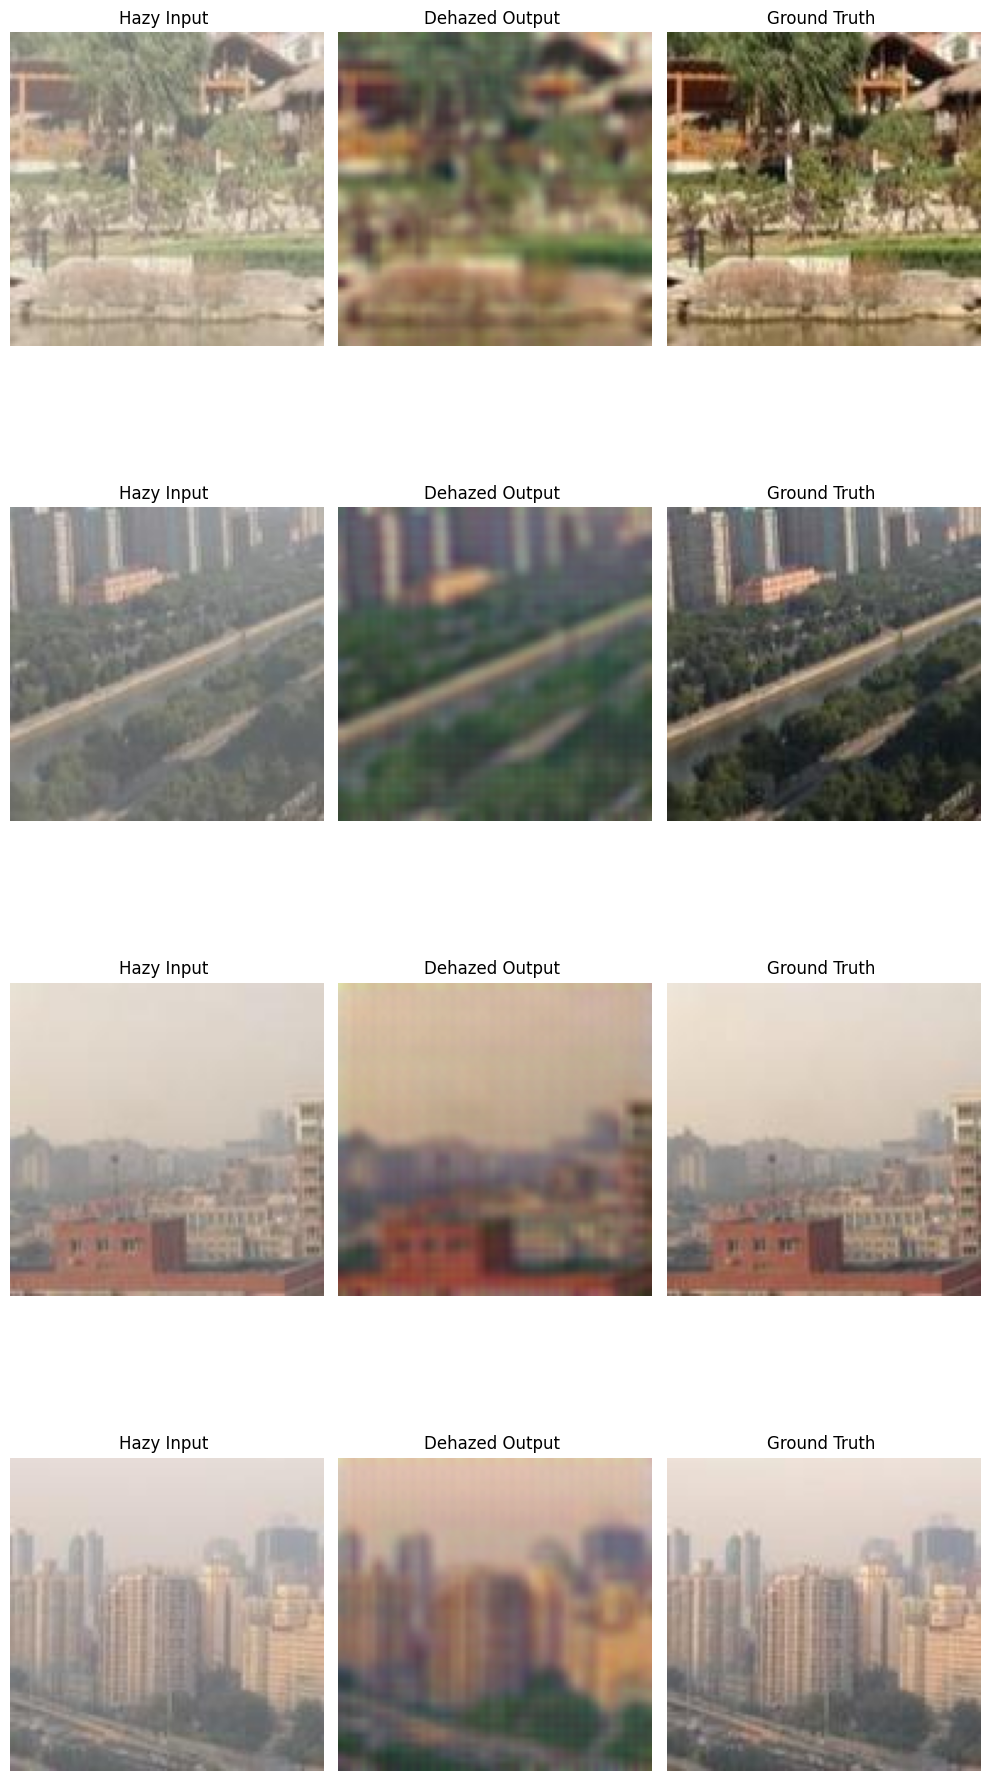

In [112]:
# -----------------------------
# INFERENCE & VISUALIZATION FOR SPECIFIC IMAGES
# -----------------------------
image_indices = [11, 12, 13,14]  # Indices of images to visualize

plt.figure(figsize=(10, len(image_indices) * 5))

for idx, i in enumerate(image_indices):
    hazy_img = Image.open(hazy_images[i+1])
    gt_img = Image.open(gt_images[i+1])

    # Transform for model input
    input_tensor = transform(hazy_img).unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        res = net(input_tensor)
        print(res[0].shape)
        output_tensor = res[0].cpu().squeeze(0)

    # Convert back to image
    output_img = to_pil(output_tensor)

    # Display results
    plt.subplot(len(image_indices), 3, 3 * idx + 1)
    plt.imshow(hazy_img)
    plt.title(f"Hazy Input ")
    plt.axis("off")

    plt.subplot(len(image_indices), 3, 3 * idx + 2)
    plt.imshow(output_img)
    plt.title(f"Dehazed Output ")
    plt.axis("off")

    plt.subplot(len(image_indices), 3, 3 * idx + 3)
    plt.imshow(gt_img)
    plt.title(f"Ground Truth ")
    plt.axis("off")

plt.tight_layout()
plt.show()


torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


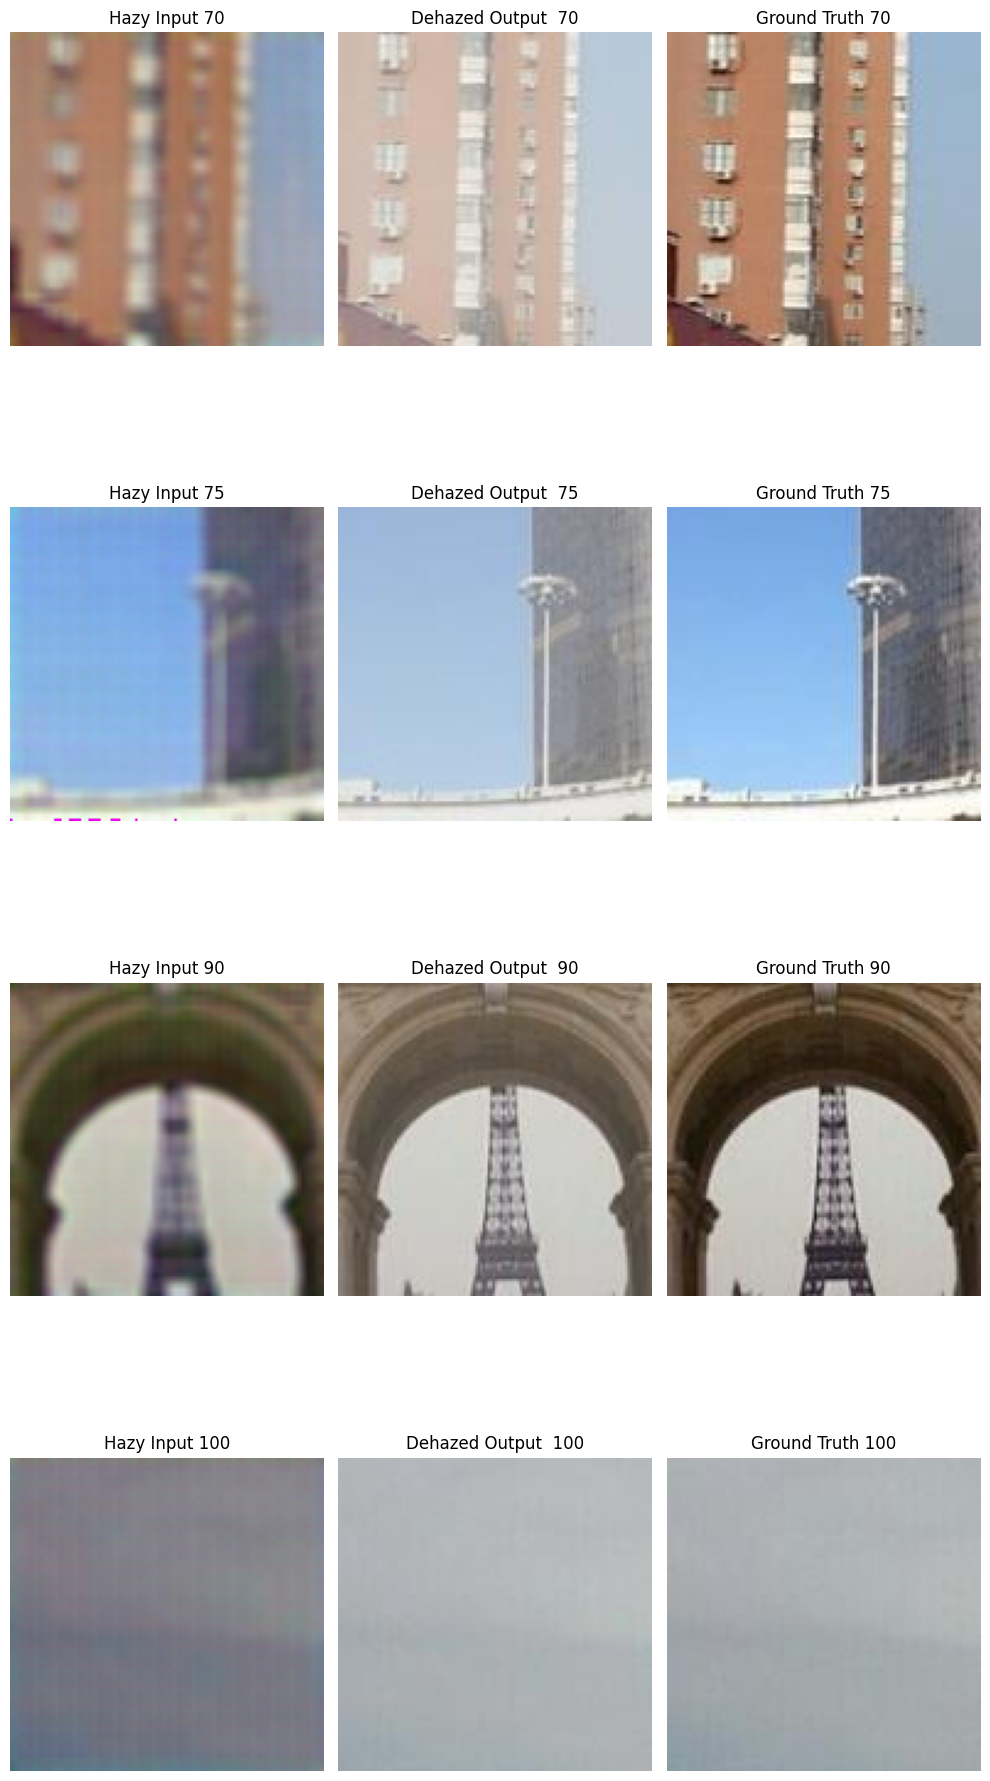

In [121]:
# -----------------------------
# INFERENCE & VISUALIZATION FOR SPECIFIC IMAGES
# -----------------------------
image_indices = [70, 75, 90, 100]  # Indices of images to visualize

plt.figure(figsize=(10, len(image_indices) * 5))

for idx, i in enumerate(image_indices):
    hazy_img = Image.open(hazy_images[i+1])
    gt_img = Image.open(gt_images[i+1])

    # Transform for model input
    input_tensor = transform(hazy_img).unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        res = net(input_tensor)
        print(res[0].shape)
        output_tensor = res[0].cpu().squeeze(0)

    # Convert back to image
    output_img = to_pil(output_tensor)

    # Display results
    plt.subplot(len(image_indices), 3, 3 * idx + 1)
    plt.imshow(output_img)
    plt.title(f"Hazy Input {i}")
    plt.axis("off")

    plt.subplot(len(image_indices), 3, 3 * idx + 2)
    plt.imshow(hazy_img)
    plt.title(f"Dehazed Output  {i}")
    plt.axis("off")
    

    plt.subplot(len(image_indices), 3, 3 * idx + 3)
    plt.imshow(gt_img)
    plt.title(f"Ground Truth {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()


torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


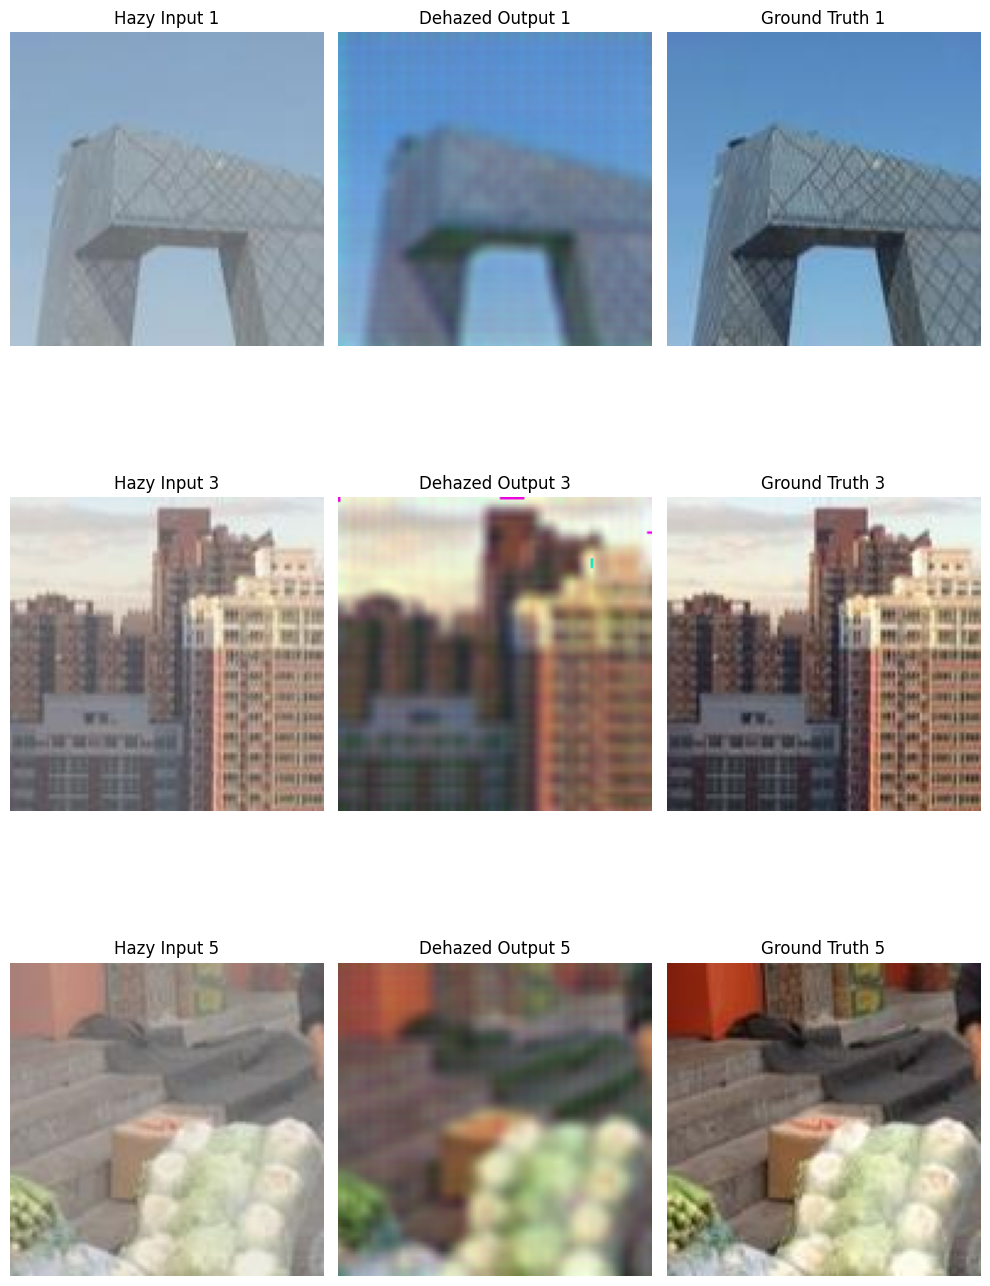

In [114]:
# -----------------------------
# INFERENCE & VISUALIZATION FOR SPECIFIC IMAGES
# -----------------------------
image_indices = [1, 3, 5]  # Indices of images to visualize

plt.figure(figsize=(10, len(image_indices) * 5))

for idx, i in enumerate(image_indices):
    hazy_img = Image.open(hazy_images[i+1])
    gt_img = Image.open(gt_images[i+1])

    # Transform for model input
    input_tensor = transform(hazy_img).unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        res = net(input_tensor)
        print(res[0].shape)
        output_tensor = res[0].cpu().squeeze(0)

    # Convert back to image
    output_img = to_pil(output_tensor)

    # Display results
    plt.subplot(len(image_indices), 3, 3 * idx + 1)
    plt.imshow(hazy_img)
    plt.title(f"Hazy Input {i}")
    plt.axis("off")

    plt.subplot(len(image_indices), 3, 3 * idx + 2)
    plt.imshow(output_img)
    plt.title(f"Dehazed Output {i}")
    plt.axis("off")

    plt.subplot(len(image_indices), 3, 3 * idx + 3)
    plt.imshow(gt_img)
    plt.title(f"Ground Truth {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [115]:
# # -----------------------------
# # INFERENCE & VISUALIZATION FOR SPECIFIC IMAGES
# # -----------------------------
# image_indices = [89, 2]  # Indices of images to visualize

# plt.figure(figsize=(10, len(image_indices) * 5))

# for idx, i in enumerate(image_indices):
#     hazy_img = Image.open(hazy_images[i+1])
#     gt_img = Image.open(gt_images[i+1])

#     # Transform for model input
#     input_tensor = transform(hazy_img).unsqueeze(0).to(device)

#     # Inference
#     with torch.no_grad():
#         res = net(input_tensor)
#         print(res[0].shape)
#         output_tensor = res[0].cpu().squeeze(0)

#     # Convert back to image
#     output_img = to_pil(output_tensor)

#     # Display results
#     plt.subplot(len(image_indices), 3, 3 * idx + 1)
#     plt.imshow(hazy_img)
#     plt.title(f"Hazy Input {i}")
#     plt.axis("off")

#     plt.subplot(len(image_indices), 3, 3 * idx + 2)
#     plt.imshow(output_img)
#     plt.title(f"Dehazed Output {i}")
#     plt.axis("off")

#     plt.subplot(len(image_indices), 3, 3 * idx + 3)
#     plt.imshow(gt_img)
#     plt.title(f"Ground Truth {i}")
#     plt.axis("off")

# plt.tight_layout()
# plt.show()


In [116]:
# image_indices = [89, 2]  # Indices of images to visualize

# plt.figure(figsize=(10, len(image_indices) * 5 * 2))  # Adjust figure size for more images

# for idx, i in enumerate(image_indices):
#     hazy_img = Image.open(hazy_images[i+1])
#     gt_img = Image.open(gt_images[i+1])
    
#     # Crop images into top and bottom halves
#     width, height = hazy_img.size
#     top_hazy = hazy_img.crop((0, 0, width, height // 2))
#     bottom_hazy = hazy_img.crop((0, height // 2, width, height))
#     top_gt = gt_img.crop((0, 0, width, height // 2))
#     bottom_gt = gt_img.crop((0, height // 2, width, height))
    
#     transform = transforms.Compose([
#         transforms.ToTensor()
#     ])
    
#     halves = [(top_hazy, top_gt, "Top"), (bottom_hazy, bottom_gt, "Bottom")]
    
#     for j, (hazy_part, gt_part, position) in enumerate(halves):
#         input_tensor = transform(hazy_part).unsqueeze(0).to(device)
        
#         # Inference
#         with torch.no_grad():
#             res = net(input_tensor)
#             output_tensor = res[0].cpu().squeeze(0)
        
#         # Convert back to image
#         output_img = transforms.ToPILImage()(output_tensor)
        
#         # Display results
#         plt.subplot(len(image_indices) * 2, 3, 6 * idx + j * 3 + 1)
#         plt.imshow(hazy_part)
#         plt.title(f"Hazy Input {i} ({position})")
#         plt.axis("off")
        
#         plt.subplot(len(image_indices) * 2, 3, 6 * idx + j * 3 + 2)
#         plt.imshow(output_img)
#         plt.title(f"Dehazed Output {i} ({position})")
#         plt.axis("off")
        
#         plt.subplot(len(image_indices) * 2, 3, 6 * idx + j * 3 + 3)
#         plt.imshow(gt_part)
#         plt.title(f"Ground Truth {i} ({position})")
#         plt.axis("off")

# plt.tight_layout()
# plt.show()


In [117]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session